In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
import psycopg2
import numpy as np
import psycopg2.extras as extras
import pandas as pd
import requests
import time

In [2]:
def sql_to_dataframe(conn, query, column_names):
    #Import data from a PostgreSQL database using a SELECT query  
    cursor = conn.cursor()  
    try:
        cursor.execute(query)
    except (Exception, psycopg2.DatabaseError) as error:      
        print("Error: %s" % error)
        cursor.close()   
        return 1   
    # The execute returns a list of tuples:
    tuples_list = cursor.fetchall()
    cursor.close()
    # Now we need to transform the list into a pandas DataFrame:
    df = pd.DataFrame(tuples_list, columns=column_names)  
    return df

In [3]:
conn = psycopg2.connect(database="dspjmain",
                        host="localhost",
                        user="postgres",
                        password="derekgrammer",
                        port="5432")

query = """
        SELECT * FROM dspjschema.track_master
        ORDER BY added_at desc
        """
column_names = ["artist_id","artist_name","album_id","album_name","album_release_date","album_total_tracks", "track_id", "track_name","duration_ms","explicit","added_at"]

db_df = sql_to_dataframe(conn, query, column_names)

In [6]:
db_df.head()


,artist_id,artist_name,album_id,album_name,album_release_date,album_total_tracks,track_id,track_name,duration_ms,explicit,added_at
0,3pulcT2wt7FEG10lQlqDJL,Amon Amarth,3cQfALGRSzDeohPsXkF6X3,Deceiver of the Gods,2013-06-25,10,7jcCt0VtoIsQ1rIcITvplO,Shape Shifter,242506,False,2023-04-06 12:46:45
1,3pulcT2wt7FEG10lQlqDJL,Amon Amarth,79GLbXCHnsOG9TBzvtS3sy,Jomsviking,2016-03-25,11,5gNyrx8elXaXXs3vFC1ufZ,Raise Your Horns,263786,False,2023-04-06 12:41:25
2,4FmJD0mpgQ70SNt2EKK8tq,Miracle Of Sound,5HF0MS5bnKVPe33rSEuYdZ,Skal (Metal Version),2023-03-24,1,1Qt5SbPsqxba4mhtF76o0I,Skal - Metal Version,179643,False,2023-04-06 12:32:03
3,4FmJD0mpgQ70SNt2EKK8tq,Miracle Of Sound,1QhzS64CeOjPBFLKuxnS6k,Skal,2023-03-10,1,4SO5r9cjaokv3HXuP1IXV5,Skal,170312,False,2023-03-30 06:05:38
4,0WPCPYm5IDNtQjuJOGNPcy,Brothers of Metal,2tWp1AYC1fW4I1gElf1s3V,Berserkir,2022-12-02,2,314iEiVWW8TGvV90ID3PIr,The Other Son of Odin,205626,False,2023-03-30 06:05:33


In [7]:
print(len(db_df))

1372


In [8]:
AUTH_URL = 'https://accounts.spotify.com/api/token'
# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': '9cdef0bc741e471385b100af843c28c5',
    'client_secret': 'a0820dd07a3e4d8facb51bb5ed5130a2',
})
# convert the response to JSON
auth_response_data = auth_response.json()
# save the access token
access_token = auth_response_data['access_token']
# used for authenticating all API calls
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}

In [9]:
#get track audio features
def get_audio_features(feature_df,track_id):
    # pull all tracks from this album
    for track in track_id:
        track_id = track
        r = requests.get(BASE_URL + 'audio-features/' + track_id, 
                         headers=headers)
        d = r.json()
        time.sleep(1)
        
        track_id = d['id']
        danceability = d['danceability']
        energy = d['energy']
        key = d['key']
        loudness = d['loudness']
        mode = d['mode']
        speechiness = d['speechiness']
        acousticness = d['acousticness']
        instrumentalness = d['instrumentalness']
        liveness = d['liveness']
        valence = d['valence']
        tempo = d['tempo']
        time_signature = d['time_signature']
        
        #save data in pd dataframe
        ##feature_df = feature_df.append({'track_id':track_id,'danceability': danceability,'energy': energy,
        ##                            'key': key,'loudness': loudness,'mode': mode,'speechiness': speechiness,'acousticness': acousticness,
        ##                            'instrumentalness': instrumentalness,'liveness': liveness,'valence': valence,'tempo': tempo,
        ##                            'time_signature': time_signature},ignore_index=True)
        temp_df = pd.DataFrame({'track_id':track_id,'danceability': danceability,'energy': energy,
                                    'key': key,'loudness': loudness,'mode': mode,'speechiness': speechiness,'acousticness': acousticness,
                                    'instrumentalness': instrumentalness,'liveness': liveness,'valence': valence,'tempo': tempo,
                                    'time_signature': time_signature},index=[1])
        feature_df = pd.concat([feature_df, temp_df], ignore_index=True)
    return feature_df

In [11]:
#Main
BASE_URL = 'https://api.spotify.com/v1/'
track_df = db_df
track_id = track_df.loc[:,'track_id']
feature_df = pd.DataFrame(columns=["track_id","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness",
                            "liveness","valence","tempo","time_signature"])
feature_df = get_audio_features(feature_df, track_id)

feature_df.to_csv(r'C:\Users\dsgra\OneDrive\Documents\GitHub\data_science_pj\01_Output\audio-features_v2.csv',encoding='utf-8-sig')
print('-----------------------------------')
print('Saved to .csv in project directory.')
print('-----------------------------------')

-----------------------------------
Saved to .csv in project directory.
-----------------------------------


In [12]:
feature_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,7jcCt0VtoIsQ1rIcITvplO,0.431,0.982,9,-4.371,0,0.0757,0.000056,0.422000,0.0603,0.269,162.031,4
1,5gNyrx8elXaXXs3vFC1ufZ,0.460,0.876,5,-5.390,1,0.0450,0.000068,0.798000,0.1510,0.499,164.992,3
2,1Qt5SbPsqxba4mhtF76o0I,0.433,0.916,0,-6.115,1,0.0673,0.101000,0.000000,0.2940,0.342,170.993,4
3,4SO5r9cjaokv3HXuP1IXV5,0.632,0.626,7,-9.890,1,0.0273,0.312000,0.000052,0.1430,0.548,84.015,4
4,314iEiVWW8TGvV90ID3PIr,0.403,0.952,7,-4.534,1,0.0810,0.000807,0.001010,0.3250,0.517,174.974,4


In [13]:
import psycopg2
import numpy as np
import psycopg2.extras as extras
import pandas as pd

# bulk insert to postgreSQL db 
def execute_values(conn, feature_df, table):
  
    tuples = [tuple(x) for x in feature_df.to_numpy()]
  
    cols = ','.join(list(feature_df.columns))
    # SQL query to execute
    query = """
            INSERT INTO %s(%s)
            VALUES %%s
            ON CONFLICT DO NOTHING
            """ % (table, cols)
     
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("the dataframe is inserted")
    cursor.close()

conn = psycopg2.connect(database="dspjmain",
                        host="localhost",
                        user="postgres",
                        password="derekgrammer",
                        port="5432")
  
execute_values(conn, feature_df, 'dspjschema.audio_features')

the dataframe is inserted


In [11]:
import matplotlib.pyplot as plt
feature_df.corr()

C:\Users\dsgra\AppData\Local\Temp\ipykernel_20708\2174715951.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  feature_df.corr()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
danceability,1.000000,-0.155864,0.014255,-0.050126,-0.022805,-0.094522,0.121947,-0.156445,-0.063659,0.501365,-0.196306,0.167326
energy,-0.155864,1.000000,-0.030418,0.713512,0.033361,0.272174,-0.634870,-0.124559,0.157056,-0.049371,0.180690,0.131115
key,0.014255,-0.030418,1.000000,-0.049188,-0.094478,0.034245,-0.004523,0.053107,0.000724,0.027238,-0.005477,-0.016842
loudness,-0.050126,0.713512,-0.049188,1.000000,0.059371,0.240353,-0.495144,-0.250861,0.138078,-0.015139,0.142304,0.129227
mode,-0.022805,0.033361,-0.094478,0.059371,1.000000,0.078305,-0.027365,-0.072812,0.041301,-0.020048,0.006596,0.013997
speechiness,-0.094522,0.272174,0.034245,0.240353,0.078305,1.000000,-0.023526,-0.105492,0.173575,-0.112774,0.198954,0.024492
acousticness,0.121947,-0.634870,-0.004523,-0.495144,-0.027365,-0.023526,1.000000,0.019298,-0.051698,0.081449,-0.087197,-0.084647
instrumentalness,-0.156445,-0.124559,0.053107,-0.250861,-0.072812,-0.105492,0.019298,1.000000,-0.030907,-0.245243,0.028934,-0.169805
liveness,-0.063659,0.157056,0.000724,0.138078,0.041301,0.173575,-0.051698,-0.030907,1.000000,0.027195,0.050423,0.026346
valence,0.501365,-0.049371,0.027238,-0.015139,-0.020048,-0.112774,0.081449,-0.245243,0.027195,1.000000,0.017962,0.157577


In [10]:
feature_df.head()

,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,1nLnpLXvl68RZCSjfkyiaa,0.559,0.543,1,-5.429,1,0.3020,0.00133,0.00002,0.0577,0.337,75.958,4
1,373gDROnujxNTFa1FojYIl,0.596,0.798,0,-4.630,1,0.0285,0.00412,0.00000,0.3380,0.459,105.010,4
2,5sNESr6pQfIhL3krM8CtZn,0.687,0.793,2,-4.254,1,0.1660,0.06030,0.00000,0.5820,0.751,107.045,4
3,4qVR3CF8FuFvHN4L6vXlB1,0.535,0.951,3,-3.324,0,0.1800,0.00777,0.00000,0.0669,0.723,160.102,4
4,6Y2kW1mdHE0znPCjtOdt5m,0.465,0.963,0,-3.568,0,0.0484,0.00161,0.00000,0.1960,0.528,160.065,4


array([[<Axes: title={'center': 'danceability'}>,
        <Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'loudness'}>],
       [<Axes: title={'center': 'mode'}>,
        <Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'instrumentalness'}>],
       [<Axes: title={'center': 'liveness'}>,
        <Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'time_signature'}>],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

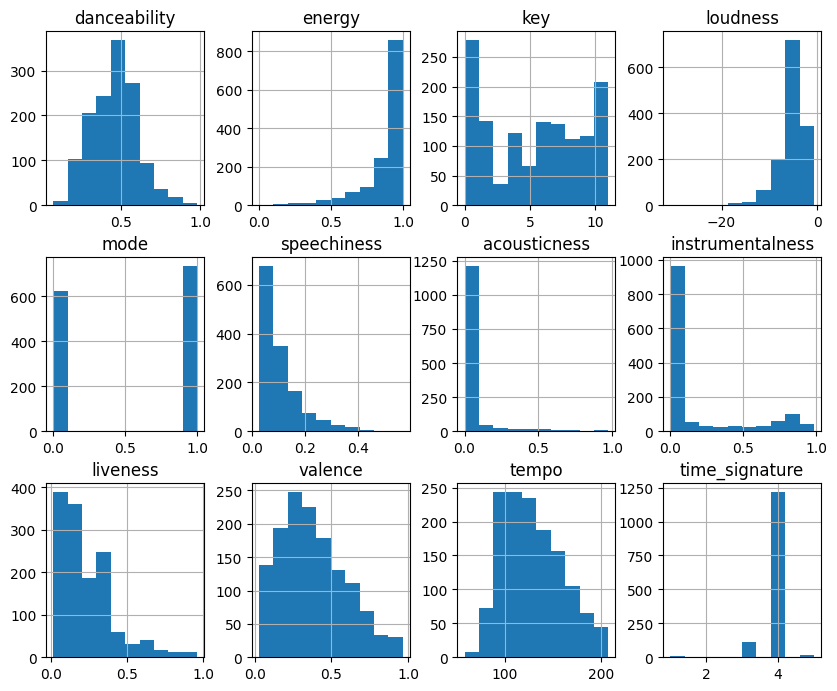

In [9]:
feature_df = pd.read_csv('audio-features_v2.csv')

feature_df.hist(figsize=(10,14),layout=(5,4))